In [1]:
import img
from PIL import Image
import numpy as np
import random

[[157. 157. 157. ... 151. 153. 154.]
 [157. 157. 157. ... 153. 153. 153.]
 [158. 158. 158. ... 155. 153. 152.]
 ...
 [113. 135. 122. ... 130. 135. 104.]
 [127. 120. 122. ... 134. 133. 124.]
 [113. 137. 131. ... 132. 127. 106.]]


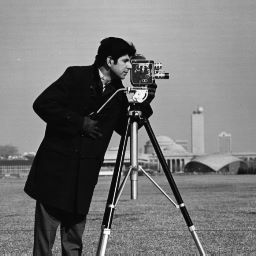

In [2]:
def showImg(im_array):
#     print(im_array.min())
    im_array = im_array - im_array.min()
    im_array = im_array/im_array.max()*255
    im_array = im_array.astype(np.uint8)
    im_show = Image.fromarray(im_array)
    return im_show

org = img.original(1)
print(org*255)
img.showImg(org)

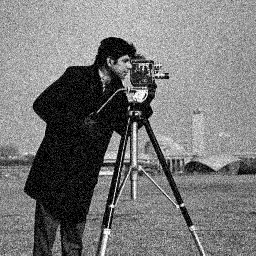

In [3]:
gaussNoised = img.gaussNoised(1,20)
img.showImg(gaussNoised)

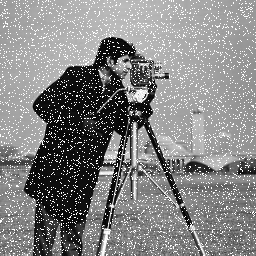

In [4]:
saltNoised = img.saltNoised(1,0.1)
img.showImg(saltNoised)

# 定义需要优化的函数

首先是TV的选择，我们用L2norm
$$
\|X\|_{T V}=\sum_{i=1}^{n-1} \sum_{j=1}^{n-1} \sqrt{\left(X_{i, j}-X_{i+1, j}\right)^{2}+\left(X_{i, j}-X_{i, j+1}\right)^{2}}
$$
然后是相似性计算，使用
$$
\text {disimilarity}=\|F-X\|_{2}^{2}
$$
最后综合一下
$$
\min _{X} \lambda\|X\|_{T V}+\|F-X\|_{2}^{2}
$$

In [5]:
def int8array2float64array(x):
    x = np.array(x)
    x = x.astype(np.float64)
    return x

In [6]:
## 计算 TV
import math
def TV(x):
    # calculate total variant of a picture x
    tv = 0
    for i in range(x.shape[0]-1):
        for j in range(x.shape[1]-1):
            diff1 = (x[i][j]-x[i+1][j])
            diff2 = (x[i][j]-x[i][j+1])
            l2_norm = math.sqrt(diff1*diff1 + diff2*diff2)
            tv+=l2_norm
    return tv
    
def TV2(x):
    # tv faster
    # calculate total variant of a picture x
    tv = 0
    for i in range(x.shape[0]-1):
        for j in range(x.shape[1]-1):
            # np.linalg.norm(x1-x2, ord=None, axis=None, keepdims=False)
            l2_norm = np.linalg.norm([x[i][j]-x[i+1][j],\
                                      x[i][j]-x[i][j+1]],ord=2)
            tv+=l2_norm
    return tv
    

In [7]:
## 计算相似性
def dissimilarity(f,x):
    # L2 norm square
    # f anf x must be the same size
    simi = 0
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            diff = (x[i][j]-f[i][j])
            simi += diff*diff
    return simi

def dissimilarity2(f,x):
    # L2 norm square
    # f anf x must be the same size
    diff = f-x
    simi = np.linalg.norm(diff.reshape(-1,1),ord=2,axis = None)
    return simi*simi


In [8]:
# 综合公式
def score(x, f, lambda_ = 0.05):
    # f is the original image, x is our denoised image
    # and lambda is the rate of denoising
#     x = int8array2float64array(x)
#     f = int8array2float64array(f)
    score_ = lambda_ * TV(x) + (1-lambda_)*dissimilarity(f,x)
    return score_


# 要计算 delta x, 就要先求函数的梯度
首先是tv部分，每个$x_{ij}$都有3个公式和他有关，公式是形似的，分别求导如下
$$
\frac{\partial}{\partial x}(\sqrt{(x-a)^{2}+(x-b)^{2}})= 
\frac{-a-b+2 x}{\sqrt{a^{2}-2 a x+b^{2}-2 b x+2 x^{2}}}
$$
和
$$
\frac{\partial}{\partial x}(\sqrt{(a-x)^{2}+(a-b)^{2}})=-\frac{a-x}{\sqrt{(a-b)^{2}+(a-x)^{2}}}
$$
然后是对dissimilarity的求导
$$
\frac{\partial}{\partial x}\left((a-x)^{2}\right)=2 x-2 a
$$

In [9]:
def delTV(L, R, U, D, LD, UR, x):
    # 输入上下左右, LD(左下), UR（右上）和x本身，求在x处的偏导
    # 此处x为 X_ij
    def delTV1(a,b,x):
        divider = a*a - 2*a*x + b*b - 2*b*x + 2*x*x
        return (-a-b+2*x)/math.sqrt(divider) if divider>0 else 0
    def delTV2(a,b,x):
        divider = math.sqrt((a-b)*(a-b)+(a-x)*(a-x))
        return (-a+x)/divider if divider>0 else 0
    return delTV1(D, R, x) + delTV2(L,LD,x) + delTV2(U,UR,x)

def delSimi(a, x):
    # 此处x为 X_ij
    return 2*x - 2*a

def delXij(f, x, i, j, lambda_):
    # return lambda_*delTV(L, R, U, D, LD, UR, x) + delSimi(a, x)
    # 注意！不能当Xij在边界上使用
    L, R, U, D, LD, UR, Xij = x[i-1][j], x[i+1][j], \
    x[i][j-1], x[i][j+1], x[i-1][j+1], x[i+1][j-1], x[i][j]
    return lambda_*delTV(L, R, U, D, LD, UR, Xij) + (1-lambda_)*delSimi(f[i][j] , x[i][j])
    
# print(delXij(f, x, 2, 3))
    

In [10]:
# 计算整张表格，边缘暂时用0代替
def delF(f, x, lambda_):
    del_f = np.zeros([x.shape[0],x.shape[1]])
    del_f = int8array2float64array(del_f)
    for i in range(x.shape[0]-2):
        for j in range(x.shape[1]-2): 
            del_f[i+1][j+1] = delXij(f, x, i+1, j+1, lambda_)
#     del_x = int8array2float64array(del_x)
    return del_f

def delX(f, x, lambda_):
    return - delF(f, x, lambda_)
    
# print(delX(f, x))

# 然后计算t，使得最优（exact search） 
使用np.array简单操作
首先转换为double精度，然后再继续

In [11]:
# given a start point x in dom f
f = gaussNoised # this is a 2-axes matrix
x = f.copy()
x = int8array2float64array(x)
f = int8array2float64array(f)
assert x is not f

In [16]:
del_f = delF(f, x, 0.3)

# print( delta_x.shape)
# 有两个数组，px and py
# delta_x = np.array(delta_x)
# delta_x.shape

In [17]:
# find the t to minimize f(x + t * delta_x)
# first, 用倍增法找到 a, b 两个点， 使得中点值小于平均值

def getABinDirT( fun , start_x , direction , f, lambda_):
    a = 0.0
    b = 0.06
    score_a = fun(start_x + a*direction, f, lambda_)
    score_b = fun(start_x + b*direction, f, lambda_)
#     print('score_a , score_b',score_a , score_b)
    if score_a == score_b:
        return [a, b]
    elif score_a < score_b:
        return [a, b]
    while score_a > score_b:
#         a = b
        b = 2*b
        score_b = fun(start_x + 2*b*direction, f, lambda_)
    return [a, b]
    
getABinDirT(score, x, -del_f, f, 0.6)

[0.0, 0.12]

In [26]:
# second, use Line Search: by Function Value
def getT1T2(a, b):
    t1 = a + (b-a) * 0.382
    t2 = a + (b-a) * 0.618
    return t1, t2

def functionValueLineSearchHelper(fun, X_kpp, del_f, delta_, Z_k_prev, x_local, f, lambda_, e,  a, b):
    t1, t2 = getT1T2(a, b)
    x1, _ = X_kpp(del_f, delta_, Z_k_prev, x_local, t1)
    x2, _ = X_kpp(del_f, delta_, Z_k_prev, x_local, t2)
    f2 = fun(x2, f, lambda_)
    f1 = fun(x1, f, lambda_)
    while (b-a) > e:
#         print([a,b], end = '')
#         print([t1, t2])
#         print('f1,f2',f1, f2)
        if f2 > f1:
            b = t2
            t2 = t1
            f2 = f1
            t1 = a + (b-a) * 0.382
            x1, _ = X_kpp(del_f, delta_, Z_k_prev, x_local, t1)
            f1 = fun(x1, f, lambda_)
        else:
            a = t1
            t1 = t2
            f1 = f2
            t2 = a + (b-a) * 0.618
            x2, _ = X_kpp(del_f, delta_, Z_k_prev, x_local, t2)
            f2 = fun(x2, f, lambda_)
#         
            
#     print('Finally, [t1, t2] =',[t1, t2])
    return t2, f2

def functionValueLineSearch(fun, X_kpp, del_f, delta_, Z_k_prev, x_local, f, lambda_, e):
    [a, b] = getABinDirT(fun, x_local, -del_f, f, lambda_)
#     print('[a, b] =',[a,b])

#     [a,b] = [1,10]
    t, score_t = functionValueLineSearchHelper(fun, X_kpp, del_f, delta_, Z_k_prev, x_local, f, lambda_, e, a, b)
#     print('t, score_t = ',t, score_t)
    return t, score_t

def test1():
    def X_kpp(del_f, delta_, Z_k, X_k, t_K):
        Z_kPlus1 = X_k - t_K*del_f
        X_kplus1 = Z_kPlus1 + delta_ * (Z_kPlus1 - Z_k)
        return X_kplus1, Z_kPlus1
    t, score_t = functionValueLineSearch(score, X_kpp, del_f, 0.5, x, x, f, 0.9, 10e-1)
    print(t, score_t)
test1()

0.07415999999999999 5098.804314856065


# 尝试使用全部代码进行测试
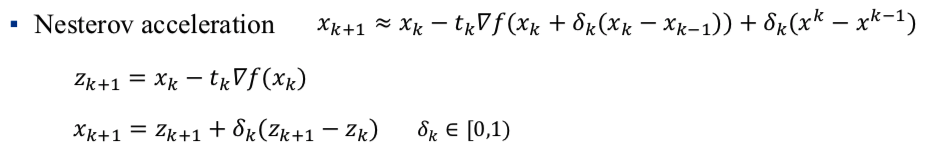

In [22]:
f = gaussNoised # this is a 2-axes matrix
x = f.copy()
x = int8array2float64array(x)
f = int8array2float64array(f)
assert x is not f

In [23]:

def l2normDelX(f, x, lambda_ = 0.05):
    del_x = delX(f, x, lambda_)
    return np.linalg.norm(del_x.reshape(-1,1),ord=2,axis = None)

def l2normDelF(del_f):
    return np.linalg.norm(del_f.reshape(-1,1),ord=2,axis = None)

l2normDelX(f, x)

25.500954439523003

In [27]:
# import copy
import time
%matplotlib inline
import matplotlib.pyplot as plt 

def imgShowInline(x_local):
    # 截掉边缘后打印
    plt.imshow(img.showImg(x_local),cmap='gray')
    plt.axis('off')
#     plt.title('iteration - '+str(i)) # 图像题目
    plt.show()
    
def bestX(fun, f, x, lambda_, delta_, e, eps, max_it):
    img.inlineImg(org, 'org')
    img.inlineImg(gaussNoised, 'gaussNoised')
#     img.showImg(gaussNoised).show()
    # e 为functionValueLineSearch 用的接近值
    # esp 为 del F norm 用的接近值
    i = 0 # iteration
    norm_del = 10
    x_local = x.copy()
    
    iteration_l = []
    norm_del_f_l = []
    score_l = []
    time_l = []
    
    Z_k_prev = x_local
    
    def X_kpp(del_f, delta_, Z_k, X_k, t_K):
        Z_kPlus1 = X_k - t_K*del_f
        X_kplus1 = Z_kPlus1 + delta_ * (Z_kPlus1 - Z_k)
        return X_kplus1, Z_kPlus1
    
    while norm_del> eps and i < max_it: 
        
        del_f = delF(f, x_local, lambda_)
        
        start = time.time()
        
        
        
        t_K, score_t = functionValueLineSearch(fun, X_kpp, del_f, delta_, Z_k_prev, x_local, f, lambda_, e)
        
        X_kplus1, Z_kPlus1 = X_kpp(del_f, delta_, Z_k_prev, x_local, t_K)
        Z_k_prev = Z_kPlus1
        
        x_local = X_kplus1
        
        end = time.time()
        iteration_l.append(i)
        time_l.append(end-start)
        score_l.append(score_t)
#         x_local = x_local + t*del_x
#         score2 = score(x_local, f, lambda_)
        norm_del = l2normDelF(-del_f)
        norm_del_f_l.append(norm_del)
#         assert score2 == score_t
        if np.floor(i/float(max_it)*100)%10 == 0: print('iteration',i,'norm2 delF',norm_del, 'score', score_t)
        if np.floor(i/float(max_it)*100)%10 == 0: 
            img.inlineImg(x_local, 'x_local it = '+str(i))
            img.sava(x_local, 'iteration-'+str(i), img_folder = 'GD-Nesterov-exact')
        i+=1
    return x_local, [iteration_l, norm_del_f_l, score_l, time_l]
        
# best_x = bestX(score, f, x, 0.999, 10e-9, 10e-3, 101)

# 尝试将数据保存为文件
iteration，norm_del_F, score_t, time(ms)

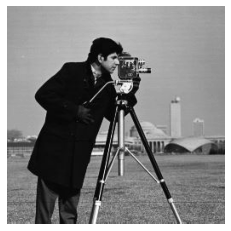

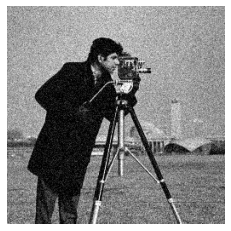

iteration 0 norm2 delF 459.0171799114141 score 4945.345363424602


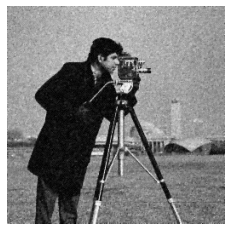

iteration 1 norm2 delF 424.4996369351876 score 3336.747461333629


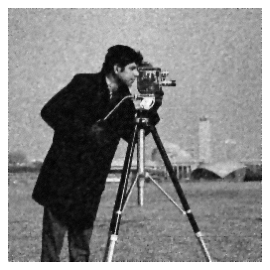

iteration 11 norm2 delF 205.98938238402596 score 1587.7459448385089


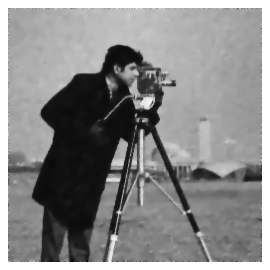

iteration 21 norm2 delF 179.57901851251646 score 1525.1629210936596


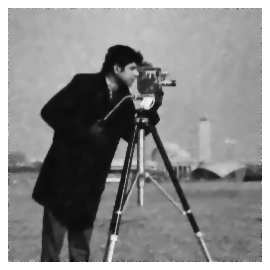

iteration 31 norm2 delF 171.65079929920637 score 1500.2194993691473


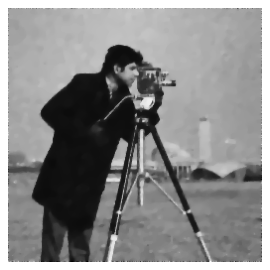

iteration 41 norm2 delF 166.884626875366 score 1485.2136602502742


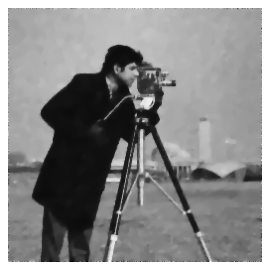

iteration 51 norm2 delF 165.09081516865112 score 1474.7345196959602


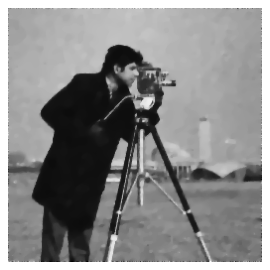

iteration 61 norm2 delF 162.5416858170332 score 1466.5251019674004


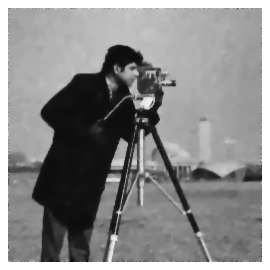

iteration 71 norm2 delF 161.56938361936673 score 1459.8922246019001


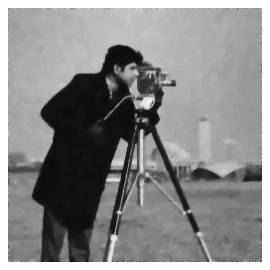

iteration 81 norm2 delF 160.0501831112593 score 1454.4547218367802


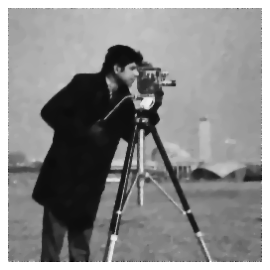

iteration 91 norm2 delF 158.54288802389596 score 1449.793498517377


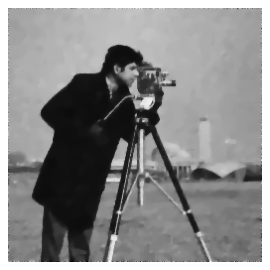

In [28]:
best_x, [iteration_l, norm_del_f_l, score_l, time_l] = bestX(score, f, x, 0.9, 0.5, 10e-9, 10e-3, 101)
img.sava(best_x, 'iteration-last', img_folder = 'GD-Nesterov-exact')

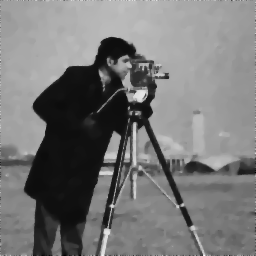

In [30]:
img.showImg(best_x)
# img.showImg(org)

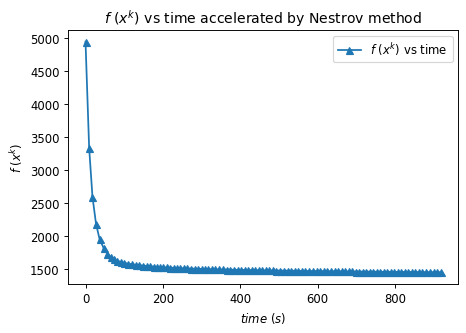

In [70]:
import matplotlib.pyplot as plt
time_l_new = [sum(time_l[:i]) for i in range(len(time_l))]
plt.plot(time_l_new, score_l, marker='^', linestyle='-',label=r'$f\ (x^{k})$'+' vs time')
plt.ylabel(r'$f\ (x^{k})$')
plt.xlabel(r'$time\ (s)$')
plt.legend()
# plt.yscale('log') 
plt.title(r'$f\ (x^{k})$ vs time accelerated by Nestrov method')
plt.savefig("./gen-img/plot/$f\ (x^{k})$ vs time accelerated by Nestrov method.png", dpi=300)
plt.show()

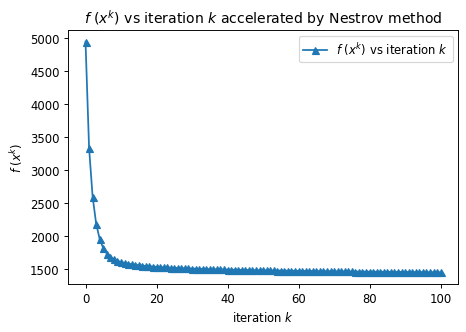

In [71]:
plt.plot(iteration_l, score_l, marker='^', linestyle='-',label=r'$f\ (x^{k})$'+' vs '+'iteration '+r'$k$')
plt.ylabel(r'$f\ (x^{k})$')
plt.xlabel('iteration '+r'$k$')
plt.legend()
plt.title(r'$f\ (x^{k})$ vs iteration $k$ accelerated by Nestrov method')
plt.savefig("./gen-img/plot/$f\ (x^{k})$ vs iteration $k$ accelerated by Nestrov method.png", dpi=300)
plt.show()

In [62]:
import pickle
def save2picke(data, file_name):
    with open('./pickle/'+file_name+'.pickle', 'wb') as f:
        pickle.dump(data, f)
        
save2picke(score_l, 'score_l for Nesterov')
save2picke(time_l, 'time_l for Nesterov')
save2picke(iteration_l, 'iteration_l for Nesterov')


In [63]:

def read4picke(file_name):
    with open('./pickle/'+file_name+'.pickle', 'rb') as f:
        return pickle.load(f)
    assert 'there is no such file' == 0
        
score_l_gd = read4picke( 'score_l for GD_primary')
time_l_gd = read4picke('time_l for GD_primary')
iteration_l_gd =read4picke( 'iteration_l for GD_primary')

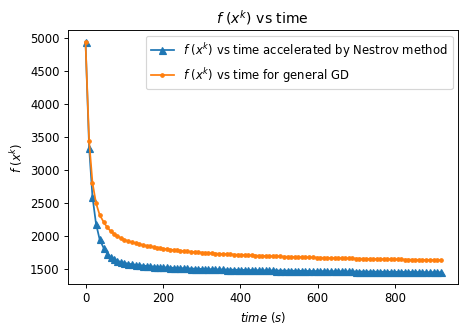

In [72]:
time_l_new = [sum(time_l[:i]) for i in range(len(time_l))]
time_l_new_gd = [sum(time_l[:i]) for i in range(len(time_l))]

plt.plot(time_l_new, score_l, marker='^', linestyle='-',label=r'$f\ (x^{k})$'+' vs time accelerated by Nestrov method')
plt.plot(time_l_new_gd, score_l_gd, marker='.', linestyle='-',label=r'$f\ (x^{k})$'+' vs time for general GD')
plt.ylabel(r'$f\ (x^{k})$')
plt.xlabel(r'$time\ (s)$')
plt.legend()
# plt.yscale('log') 
plt.title(r'$f\ (x^{k})$'+' vs time ')
plt.savefig("./gen-img/plot/$f\ (x^{k})$ vs time $k$.png", dpi=300)
plt.show()

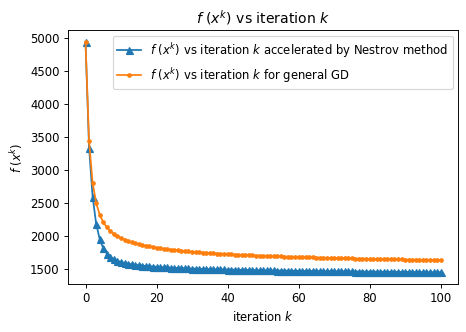

In [73]:



plt.plot(iteration_l, score_l, marker='^', linestyle='-',label=r'$f\ (x^{k})$'+' vs '+'iteration '+r'$k$ accelerated by Nestrov method'  )
plt.plot(iteration_l_gd, score_l_gd, marker='.', linestyle='-',label=r'$f\ (x^{k})$'+' vs '+'iteration '+r'$k$ for general GD')
plt.ylabel(r'$f\ (x^{k})$')
plt.xlabel('iteration '+r'$k$')
plt.legend()
plt.title(r'$f\ (x^{k})$'+' vs '+'iteration '+r'$k$''')
plt.savefig("./gen-img/plot/$f\ (x^{k})$ vs iteration $k$.png", dpi=300)
plt.show()